In [10]:
devtools::install_github("clairbarnes/rwwa")
suppressMessages(library(rwwa))

library(copula)

Skipping install of 'rwwa' from a github remote, the SHA1 (4260902d) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
library(copula)

# compute joint exceedances over regular grid for easy plotting
copula_mesh <- function(mdl_x, mdl_y, copula, cov1, xrange, yrange, n = 32) {
    
    # compute joint exceedances over regular grid for easy plotting
    
    if(missing(xrange)) xrange <- range(pretty(mdl_x$x))
    if(missing(yrange)) yrange <- range(pretty(mdl_y$x))
    
    # define the regular mesh for plotting
    x_mesh <- seq(xrange[1], xrange[2],length.out = n)
    y_mesh <- seq(yrange[1], yrange[2], length.out = n)
    
    # convert the regular mesh to U space
    x_umesh <- map_to_u(mdl_x, x_mesh, fixed_cov = cov1)
    y_umesh <- map_to_u(mdl_y, y_mesh, fixed_cov = cov1)
    
    if(substr(mdl_x$varnm,1,5) == "log10") { x_mesh <- 10^x_mesh }
    if(substr(mdl_y$varnm,1,5) == "log10") { y_mesh <- 10^y_mesh }
    
    return(list("x" = x_mesh, "y" = y_mesh, "z" = sapply(y_umesh, function(y) sapply(x_umesh, function(x) pCopula(cbind(x,y), copula)))))
}

---
# Decomposition of a bivariate compound index

In [3]:
# load covariate data
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))
nino$nino_pos <- nino$nino
nino$nino_pos[nino$nino <= 0] <- 0

# load time series of interest
pet <- read.csv("ts/cx_pet6_ms.csv")
pr <- read.csv("ts/cx_pr6_ms.csv", col.names = c("year", "pr"))

# compile into single dataframe
df <- merge(merge(merge(gmst, nino), pet), pr)

# covariates to define scenarios
cov_2023 <- df[df$year == 2023,c("gmst", "nino", "nino_pos"),drop = F]

cov_cf <- rbind("histnino" = cov_2023 - c(1.2,0,0),
                "2023neut" = c(0,0,0),
                "histneut" = c(-1.2,0,0))

## Check marginals: pet, pr ~ gmst + nino

In [4]:
# fit marginal distributions

models_pet <- sapply(list("GMST only" = "gmst", "GMST + ENSO" = c("gmst", "nino"), "GMST + Nino" = c("gmst", "nino_pos")), function(covariates) {
    fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = covariates, lower = F)
}, simplify = F)

models_pr <- sapply(list("GMST only" = "gmst", "GMST + ENSO" = c("gmst", "nino"), "GMST + Nino" = c("gmst", "nino_pos")), function(covariates) {
    fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm = covariates, lower = T)
}, simplify = F)

In [5]:
print("PET:")
rbind("aic" = sapply(models_pet, aic), sapply(models_pet, rsquared))

[1] "PET:"


,GMST only,GMST + ENSO,GMST + Nino
aic,373.1025583,374.8751532,371.8046204
r2,0.6778241,0.6794481,0.7005911
r2.adj,0.6703316,0.6641837,0.6863335


In [6]:
print("Precip:")
rbind("aic" = sapply(models_pr, aic), sapply(models_pr, rsquared))

[1] "Precip:"


,GMST only,GMST + ENSO,GMST + Nino
aic,501.596007591,497.85810025,489.2972876
r2,0.001912996,0.13216271,0.2777579
r2.adj,-0.021298330,0.09083713,0.2433654


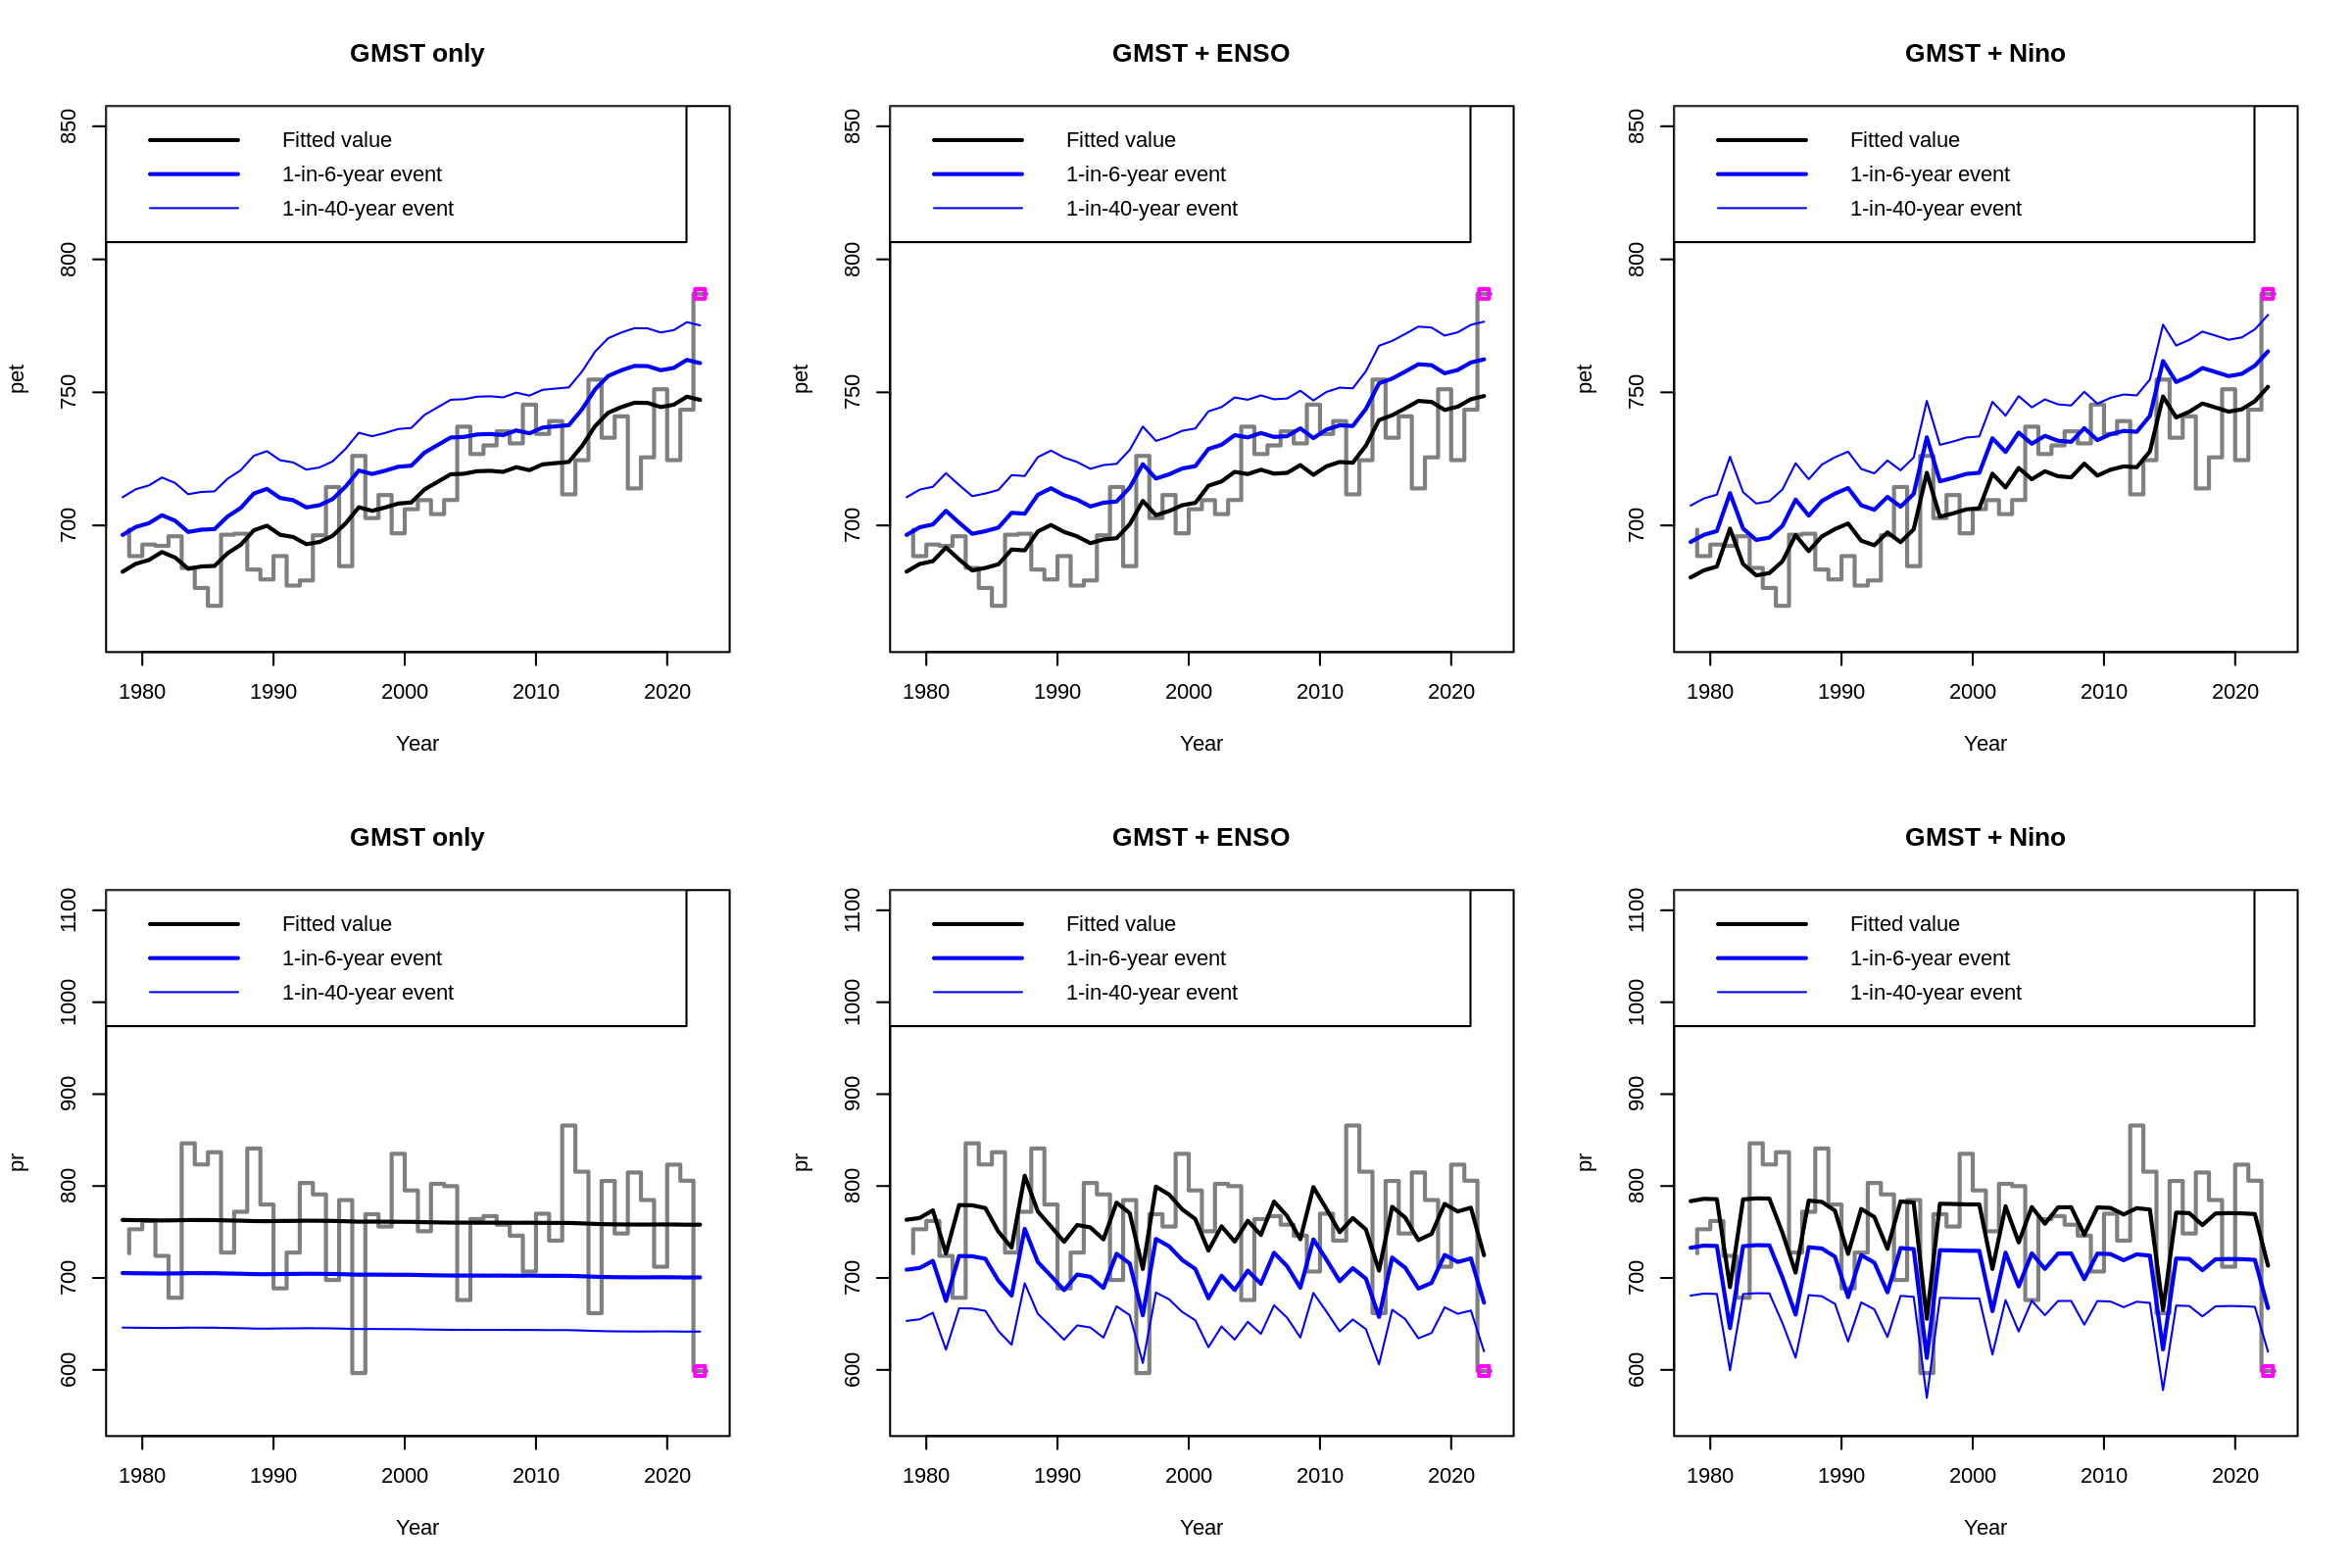

In [7]:
prep_window(c(2,3))

for(mnm in names(models_pet)) plot_trend(models_pet[[mnm]], main = mnm, ylim = c(660,850))
for(mnm in names(models_pr)) plot_trend(models_pr[[mnm]], main = mnm, ylim = c(550,1100))


## Check copula fit

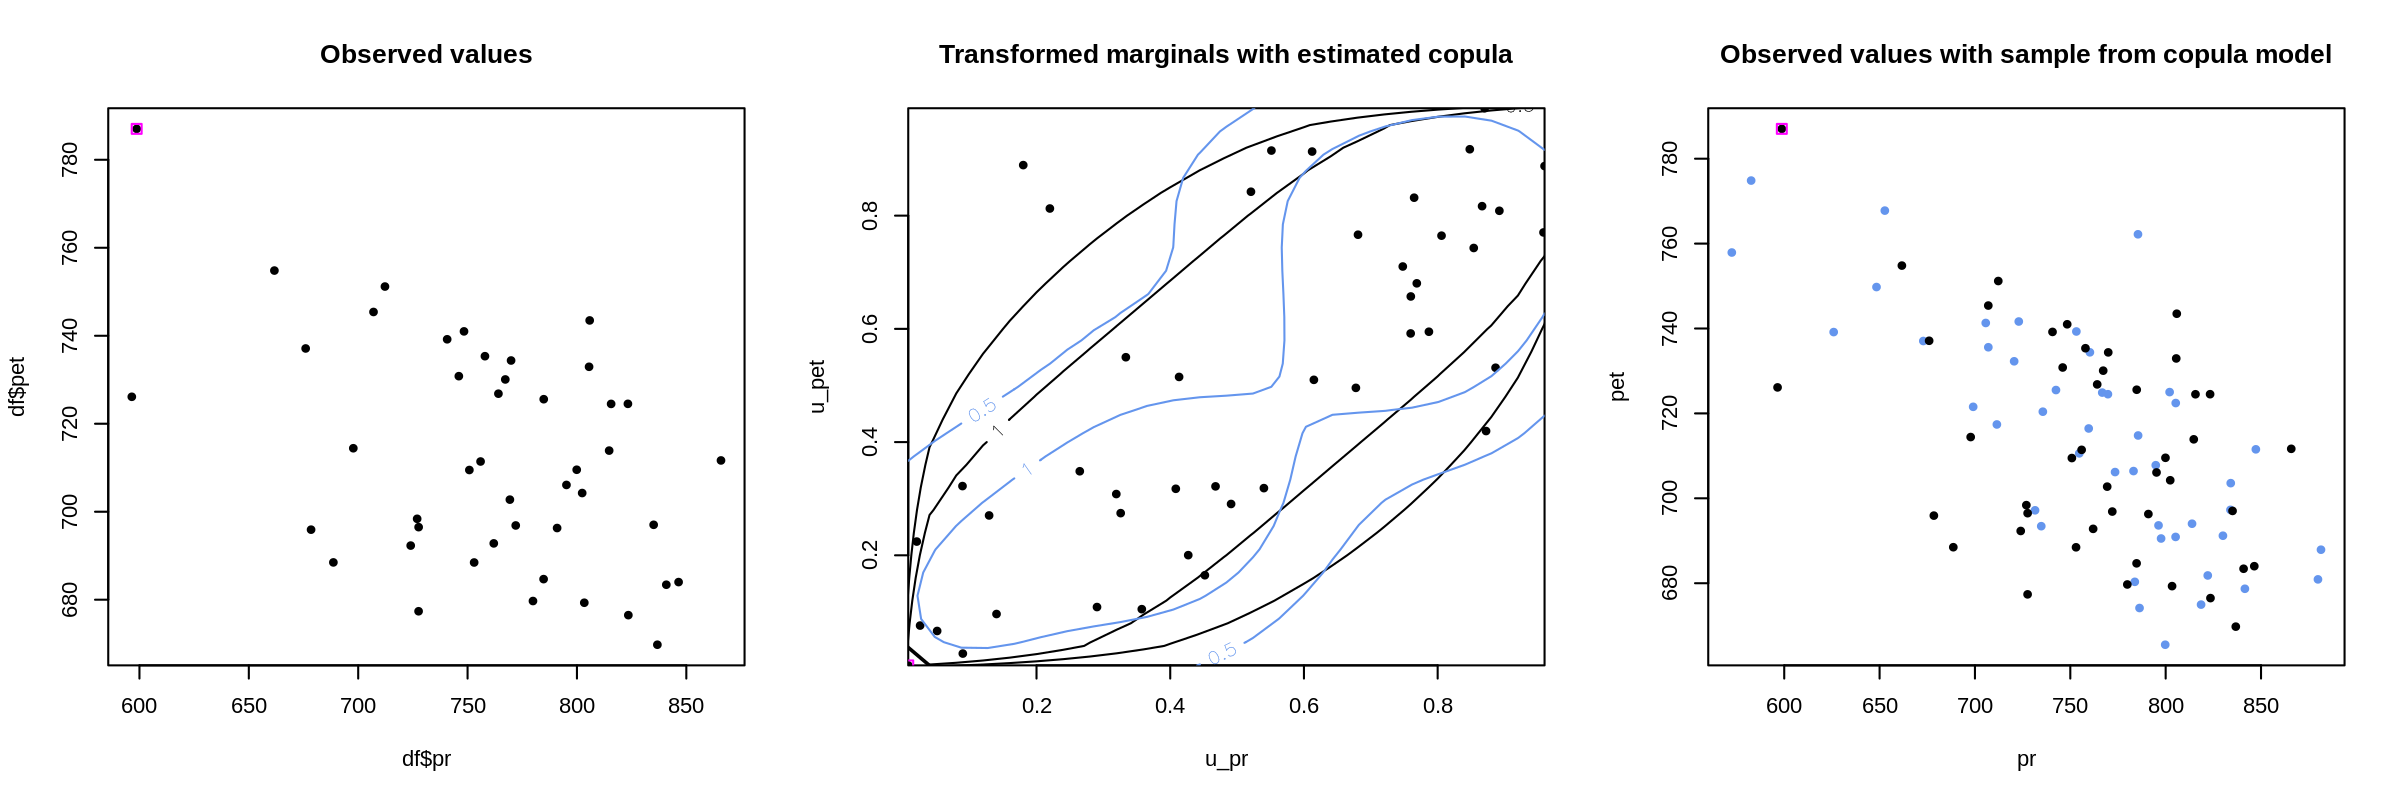

In [8]:
# fit marginal distributions
mdl_pet <- fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = c("gmst", "nino_pos"), lower = F)
mdl_pr <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm = c("gmst", "nino_pos"), lower = T)  

# transform marginals to U
u_pr <- map_to_u(mdl_pr)
u_pet <- map_to_u(mdl_pet)

fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_pet), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting

prep_window(c(1,3))

plot(df$pr, df$pet, main = "Observed values")
points(df[df$year == 2023,c("pr","pet")], col = "magenta", pch = 0)

# check fit of copula against 2d KDE
plot(u_pr, u_pet, main = "Transformed marginals with estimated copula", xaxs = "i", yaxs = "i")
points(u_pr[df$year == 2023], u_pet[df$year == 2023], col = "magenta", pch = 0)

cop <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))
contour(cop, dCopula, add = T, levels = c(0.5,1))
contour(MASS::kde2d(u_pr, u_pet), col = "cornflowerblue", add = T, levels = c(0.5,1))

# generate a sample from the fitted copula to check relationship with actual values
# MVDC needs copula fitted without accounting for lower/upper tails, since it also uses the actual marginals - adjust correlation accordingly
fitted_mvdc <- mvdc(copula = tCopula(-coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0)), 
                    margins=c("norm", "norm"), paramMargins=list(list(mean=mean(df$pr), sd=sd(df$pr)), list(mean=mean(df$pet), sd=sd(df$pet))))

set.seed(42)
mvsamp <- rMvdc(nrow(df), fitted_mvdc)

plot(mvsamp, col = "cornflowerblue", xlim = range(mvsamp[,1], df$pr), ylim = range(mvsamp[,2], df$pet), xlab = "pr", ylab = "pet",
     main = "Observed values with sample from copula model")
points(df$pr, df$pet, pch = 20, col = "black")
points(df[df$year == 2023,c("pr","pet")], col = "magenta", pch = 0)

## Fit chosen model & get contour values

In [9]:
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))

In [10]:
# get expected return levels in factual & counterfactual climates
rp_pr <- return_period(mdl_pr)[nrow(df)]
rl_pr <- as.list(c("2023" = eff_return_level(mdl_pr, rp_pr, fixed_cov = cov_2023), 
                               sapply(rownames(cov_cf), function(rnm) eff_return_level(mdl_pr, rp_pr, fixed_cov = cov_cf[rnm,,drop = F]))))

rp_pet <- return_period(mdl_pet)[nrow(df)]
rl_pet <- as.list(c("2023" = eff_return_level(mdl_pet, rp_pet, fixed_cov = cov_2023), 
                               sapply(rownames(cov_cf), function(rnm) eff_return_level(mdl_pet, rp_pet, fixed_cov = cov_cf[rnm,,drop = F]))))

In [11]:
# joint return periods
joint_rp <- as.list(c("2023" = 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_2023), map_to_u(mdl_pet, mdl_pet$ev, cov_2023)), cfit),
  sapply(rownames(cov_cf), function(rnm) 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_cf[rnm,,drop = F]), map_to_u(mdl_pet, mdl_pet$ev, cov_cf[rnm,,drop = F])), cfit))))
joint_rp

$`2023`
[1] 462.4431

$histnino
[1] -4.793054e+16

$`2023neut`
[1] 5475.559

$histneut
[1] 2.809197e+17

In [12]:
# double- check using PI marginals & ERLs - should give the same joint return period as today's event in today's climate
1/pCopula(c(map_to_u(mdl_pr, rl_pr$histnino, cov_cf["histnino",,drop = F]), map_to_u(mdl_pet, rl_pet$histnino, cov_cf["histnino",,drop = F])), cfit)

[1] 462.4431

In [13]:
cmesh_2023 <- copula_mesh(mdl_pr, mdl_pet, cfit, cov_2023, xrange = c(550,900), yrange = c(550,800), n = 64)
cmesh_hist <- copula_mesh(mdl_pr, mdl_pet, cfit, cov_cf["histnino",,drop = F], xrange = c(550,900), yrange = c(550,700))

### Contour plot

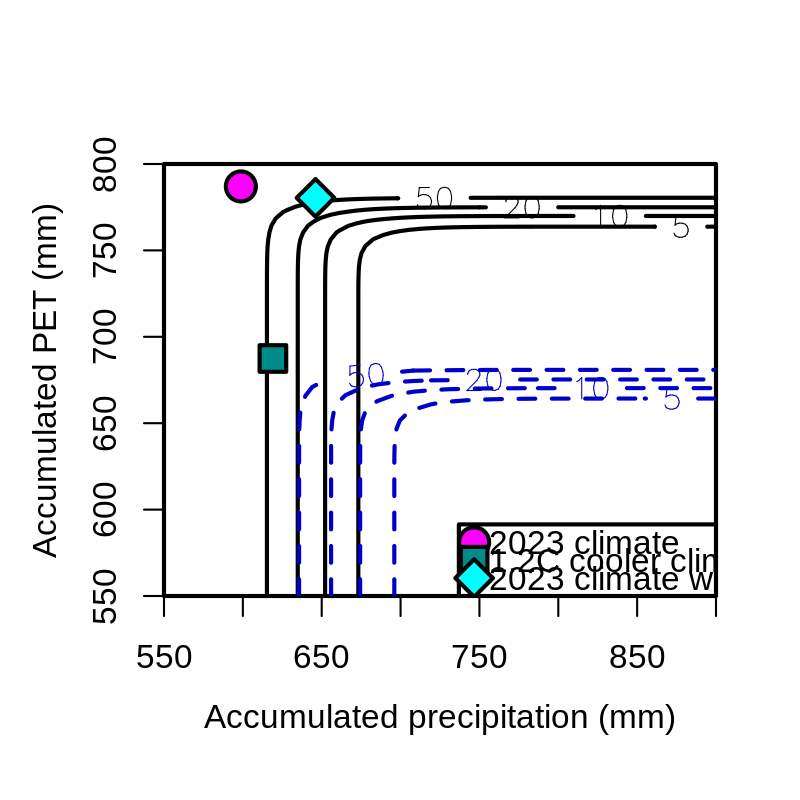

In [14]:
# check that plot region covers all contours & features of interest
prep_window(c(1,1), lwd = 2)

pt.cex = 2

pr_x = seq(550,900,5)
pet_y = seq(550,800,5)
    
matplot(0, type = "n", xlim = range(pr_x), ylim = range(pet_y), xlab = "", ylab = "", main = "", xaxs = "i", yaxs = "i")

contour(cmesh_2023, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "black", labcex = par("cex.lab"), add = T)

mtext("Accumulated precipitation (mm)", 1, line = 2.5, cex = par("cex.lab"))
mtext("Accumulated PET (mm)", 2, line = 2.5, cex = par("cex.lab"))
# mtext("Joint return levels of PET/PR\nwith SPEI drought class", 3, line = 1, font = 2, cex = par("cex.main"))

contour(cmesh_hist, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "blue3", lty = 2, labcex = par("cex.lab"), add = T)

# points(mdl_pr$x, mdl_pet$x, pch = 20)

points(mdl_pr$ev, mdl_pet$ev, pch = 21, bg = "magenta", cex = pt.cex)
points(rl_pr$"histnino", rl_pet$"histnino", pch = 22, bg = "cyan4", cex = pt.cex)
points(rl_pr$"2023neut", rl_pet$"2023neut", pch = 23, bg = "cyan", cex = pt.cex)

legend("bottomright", legend = c("2023 climate", "1.2C cooler climate", "2023 climate without El Nino"), pch = c(21,22,23),
       pt.bg = c("magenta", "cyan4", "cyan"), pt.cex = pt.cex, cex = par("cex.lab"))

## Compute gridded SPEI for filled contours

In [65]:
library("SPEI")

# Package SPEI (1.8.1) loaded [try SPEINews()].



In [66]:
# create time series of effective precip
eff_pr <- ts((df$pr - df$pet)[(df$year >= 1990) & (df$year <= 2020)], start = 1990, frequency = 1)
fitted_spei <- spei(eff_pr, scale = 1, verbose = F)

# get intercept of SPEI - can use this to draw polygons for the successive drought categories
spei_0 <- sapply(0:850, function(pe) spei(ts(550 - pe), scale = 1, params = coef(fitted_spei), verbose = F)$fitted)
spei_int <- function(x) which.min(abs(spei_0 - x)) - 550

### Contour plot

In [96]:
# check that plot region covers all contours & features of interest
prep_window(c(1,1), lwd = 2)

pt.cex = 2

pr_x = seq(550,900,5)
pet_y = seq(550,800,5)

drought_cols = c("yellow1", "gold", "chocolate1", "red2", "darkred")
nc = length(drought_cols)

pdf("fig/decomposition.pdf", width = 8, height = 7, bg = "white"); par(lwd = 2, mar = c(3.6,3.6,1,1), cex.main = 2, cex.axis = 1.4, cex.lab = 1.3); {
    
    layout(matrix(c(1,2), 1, 2, byrow = TRUE), widths=c(9,1.5))
    
    matplot(0, type = "n", xlim = range(pr_x), ylim = range(pet_y), xlab = "", ylab = "", main = "", xaxs = "i", yaxs = "i")

    # add drought categories
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-0.5), rev(pr_x + spei_int(-0.8))), density = NULL, border = NA, col = drought_cols[1])
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-0.8), rev(pr_x + spei_int(-1.3))), density = NULL, border = NA, col = drought_cols[2])
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-1.3), rev(pr_x + spei_int(-1.6))), density = NULL, border = NA, col = drought_cols[3])
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-1.6), rev(pr_x + spei_int(-2))), density = NULL, border = NA, col = drought_cols[4])
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-2), rev(pr_x + spei_int(-20))), density = NULL, border = NA, col = drought_cols[5])
    box(lwd = 1)
    
    contour(cmesh_2023, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "black", labcex = par("cex.lab"), add = T)

    mtext("Accumulated precipitation (mm)", 1, line = 2.5, cex = par("cex.lab"))
    mtext("Accumulated PET (mm)", 2, line = 2.5, cex = par("cex.lab"))
    # mtext("Joint return levels of PET/PR\nwith SPEI drought class", 3, line = 1, font = 2, cex = par("cex.main"))

    contour(cmesh_hist, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "blue3", lty = 2, labcex = par("cex.lab"), add = T)

    # points(mdl_pr$x, mdl_pet$x, pch = 20)
    
    points(mdl_pr$ev, mdl_pet$ev, pch = 21, bg = "magenta", cex = pt.cex)
    points(rl_pr$"histnino", rl_pet$"histnino", pch = 22, bg = "cyan4", cex = pt.cex)
    points(rl_pr$"2023neut", rl_pet$"2023neut", pch = 23, bg = "cyan", cex = pt.cex)
    
    legend("bottomright", legend = c("2023 climate", "1.2C cooler climate", "2023 climate without El Nino"), pch = c(21,22,23),
           pt.bg = c("magenta", "cyan4", "cyan"), pt.cex = pt.cex, cex = par("cex.lab"))
    
    par(mar=c(3.5,0,2.5,4.5))
    plot(x=rep(1,nc+1), y=1:(nc+1), col=c("white", drought_cols), xaxt = "n", yaxt = "n", xlab = "", ylab = "", ylim = c(0.75,nc+1.25))
    for(i in 1:nc) rect(0,i+.5,2,i+1.5, col = drought_cols[i], border = NA)
    axis(4, at = 1:(nc+1), labels = c("-", paste0("D", (1:nc)-1)), las = 1)
    mtext("Drought classification", 4, line = 3, cex = par("cex.lab"))
    box()
    
}; dev.off()

png 
  2

# Function to fit copula to marginals

## New methods

### `fit_copula`

In [2]:
# method to fit the joint model
fit_copula <- function(mdl_x, mdl_y, copulatype = tCopula()) {
    
    # transform marginals to U
    u_x <- map_to_u(mdl_x)
    u_y <- map_to_u(mdl_y)
    
    # Fit the copula and extract a copula object - need to generalise this
    if(is(copulatype, "tCopula")) {
        fitted_copula <- fitCopula(tCopula(), data = cbind(u_x, u_y), hideWarnings = T)
        cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"],0), df.fixed = T) # integer DF needed for eg. pCopula & goodness of fit
    } else {
        print("Copula type not yet implemented")
        return(NULL)
    }
    
    # output 
    return(list(mdl_x = mdl_x, mdl_y = mdl_y, copula = cfit))
}

### `plot_fitted_copula`

In [15]:
plot_fitted_copula <- function(joint_model, main = "Transformed marginals\nwith fitted copula") {
    
    # transform marginals to U
    u_x <- map_to_u(joint_model$mdl_x)
    u_y <- map_to_u(joint_model$mdl_y)
    
    # generate sample from the copula
    samp <- rCopula(length(u_x), joint_model$copula)
    
    plot(u_x, u_y, col = "black", pch = 20, main = main)
    points(samp, col = "cornflowerblue", pch = 1)
    
    contour(MASS::kde2d(u_x, u_y), col = "black", add = T, levels = c(0.5,1))
    contour(joint_model$copula, dCopula, add = T, col = "cornflowerblue", lty = 2, levels = c(0.5,1))
} 

### `joint_returnperiod`

In [46]:
joint_returnperiod <- function(joint_model, fixed_cov, ev_x, ev_y) {
    
    if(missing(ev_x)) ev_x <- joint_model$mdl_x$ev
    if(missing(ev_y)) ev_y <- joint_model$mdl_y$ev
    
    setNames(sapply(1:nrow(fixed_cov), function(i)  {
        1/pCopula(c(map_to_u(joint_model$mdl_x, ev_x, fixed_cov[i,,drop = F]), map_to_u(joint_model$mdl_y, ev_y, fixed_cov[i,,drop = F])), joint_model$copula)
    }), rownames(fixed_cov))
}

### `copula_mesh`

In [5]:
copula_mesh <- function(joint_model, fixed_cov, xrange, yrange, n = 32) {
    
    # compute joint exceedances over regular grid for easy plotting
    mdl_x <- joint_model$mdl_x
    mdl_y <- joint_model$mdl_y
    
    if(missing(xrange)) xrange <- range(pretty(mdl_x$x))
    if(missing(yrange)) yrange <- range(pretty(mdl_y$x))
    
    # define the regular mesh for plotting
    x_mesh <- seq(xrange[1], xrange[2],length.out = n)
    y_mesh <- seq(yrange[1], yrange[2], length.out = n)
    
    # convert the regular mesh to U space
    x_umesh <- map_to_u(mdl_x, x_mesh, fixed_cov = fixed_cov)
    y_umesh <- map_to_u(mdl_y, y_mesh, fixed_cov = fixed_cov)
    
    return(list("x" = x_mesh, "y" = y_mesh, "z" = sapply(y_umesh, function(y) sapply(x_umesh, function(x) pCopula(cbind(x,y), joint_model$copula)))))
}

### `plot_joint_contour`

In [6]:
plot_joint_contour <- function(joint_model, fixed_cov, add = F, rp = c(5,10,20,50), xlim, ylim, ...) {
    
    if(nrow(fixed_cov) > 1) {
        cat("More than one set of covariates provided - only showing first set, plot others separately")
        fixed_cov <- fixed_cov[1,,drop = F]
    }
    
    if(missing(xlim)) { if(add) { xlim <- par("usr")[1:2] } else { xlim <- range(pretty(joint_model$mdl_x$x)) }}
    if(missing(ylim)) { if(add) { ylim <- par("usr")[3:4] } else { ylim <- range(pretty(joint_model$mdl_y$x)) }}
    
    cmesh <- copula_mesh(joint_model, fixed_cov = fixed_cov, xrange = xlim, yrange = ylim)
    contour(cmesh, levels = 1/rp, labels = rp, xaxs = "i", yaxs = "i", add = add, ...)
}

### `plot_joint_event`

In [7]:
plot_joint_event <- function(joint_model, fixed_cov, ...) {
    
    # will need to be generalised to case where data isn't indexed annually
    erl_x <- stransform(joint_model$mdl_x, fixed_cov = fixed_cov)[joint_model$mdl_x$data$year == joint_model$mdl_x$ev_year]
    erl_y <- stransform(joint_model$mdl_y, fixed_cov = fixed_cov)[joint_model$mdl_y$data$year == joint_model$mdl_y$ev_year]
    
    points(erl_x, erl_y, ...)
}

## Worked example

In [8]:
# load covariate data
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))
nino$nino_pos <- nino$nino
nino$nino_pos[nino$nino <= 0] <- 0

# load time series of interest
pet <- read.csv("ts/cx_pet6_ms.csv")
pr <- read.csv("ts/cx_pr6_ms.csv", col.names = c("year", "pr"))

# compile into single dataframe
df <- merge(merge(merge(gmst, nino), pet), pr)

# covariates to define scenarios
cov_2023 <- df[df$year == 2023,c("gmst", "nino", "nino_pos"),drop = F]

cov_cf <- rbind("histnino" = cov_2023 - c(1.2,0,0),
                "2023neut" = c(0,0,0),
                "histneut" = c(-1.2,0,0))

In [11]:
# fit marginal distributions as usual - these will be passed to the copula method
mdl_pet <- fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = c("gmst", "nino_pos"), lower = F)
mdl_pr <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm = c("gmst", "nino_pos"), lower = T)

# fit joint model using t copula (default choice)
jmodel <- fit_copula(mdl_pr, mdl_pet)

In [39]:
joint_returnperiod(jmodel, fixed_cov = cov_2023, ev_x = 1000, ev_y = 800)

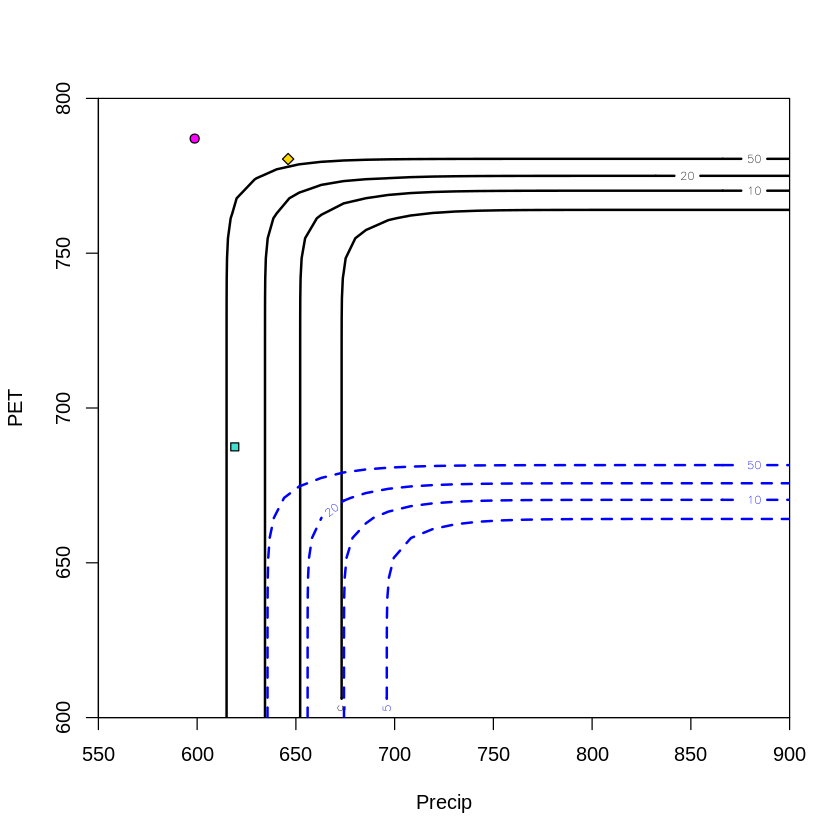

In [12]:
# plot the fitted model
plot_joint_contour(jmodel, cov_2023, lwd = 2, xlab = "Precip", ylab = "PET", ylim = c(600,800))
plot_joint_contour(jmodel, cov_cf["histnino",,drop = F], lwd = 2, col = "blue", lty = 2, add = T)

plot_joint_event(jmodel, cov_2023, pch = 21, bg = "magenta")
plot_joint_event(jmodel, cov_cf["histnino",,drop = F], pch = 22, bg = "turquoise")
plot_joint_event(jmodel, cov_cf["2023neut",,drop = F], pch = 23, bg = "gold")

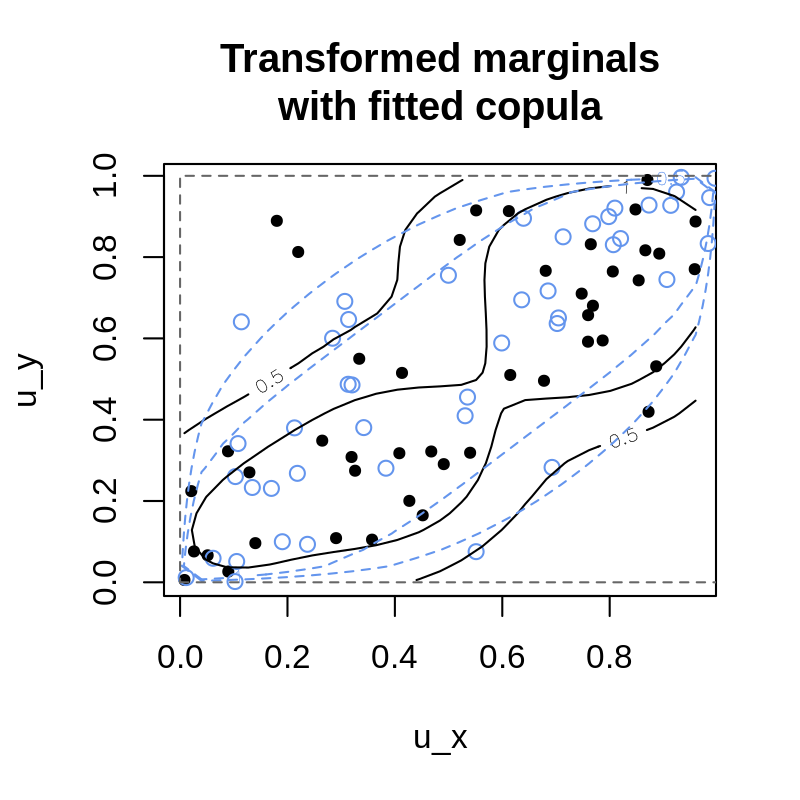

In [16]:
prep_window(c(1,1))
plot_fitted_copula(jmodel)